# Development of TDI filter
Some aPCI studies will may want as a diagnostic, comparison, or reference, a representation of kernel that is applied by the TDI algorithm, or some approximant.  

## Reverse engineering the TDI kernel
We had tools that could be applied for this from ground up in the old pylisa code, but it would be most valuable to be able to match with the actual kernels used in pyTDI sometimes.   Getting all the conventions and details right can be hard.  I did not notice a straightforward way to get this kernel info from the pyTDI code functions, because that isn't really how the calculation is organized at least at top level.  Fortunately it should be straightforward to extract this from the pyTDI code as a black box by probing it's impulse response.

In [1]:
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi import Data
import h5py
import numpy as np
import copy
import pcipy

if 0:
    datadir = "/data/jgbaker/software/pylisa/data/"
    orbits = datadir+"keplerian-orbits.h5"
    workdir = datadir+"/simulations/"
    noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
    gw_file_base = "2025-07-01_19h34_"
    dtpath = "2024-04-10_18h14_"
if 1: 
    datadir = "/data/jgbaker/software/pcipy/data"
    workdir = datadir+"/simulations/"
    if 1:
        orbits = workdir+"keplerian-orbits.h5"
        noise_file_base = "2025-04-07_keplerian_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_keplerian_"
    else:
        orbits = workdir+"equalarm-orbits.h5"
        noise_file_base = "2025-04-07_equalarm_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_equalarm_"
        

In [2]:
##This is the code for computing TDI as we do it in noise_simulation:
if 0:  #the code is just to look at
    data_noise = Data.from_instrument(instr)
    if args.tdi == '2':
        X, Y, Z = X2, Y2, Z2
    else:
        X, Y, Z = X1, Y1, Z1
    # Build other 2.0 Michelson variables
    X_data = X.build(**data_noise.args)
    Y_data = Y.build(**data_noise.args)
    Z_data = Z.build(**data_noise.args)
    # Apply TDI 2.0
    x_noise = X_data(data_noise.measurements)
    y_noise = Y_data(data_noise.measurements)
    z_noise = Z_data(data_noise.measurements)

In [3]:
# If we use a file
#simpath = workdir + dtpath + 'measurements_4Hz.h5'
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')

# load data
data_noise = Data.from_instrument(simpath)

fs = data_noise.fs

You are using a measurement file in a version that might not be fully supported


In [4]:
# Build other 2.0 Michelson variables
X_data_op = X2.build(**data_noise.args)
Y_data_op = Y2.build(**data_noise.args)
Z_data_op = Z2.build(**data_noise.args)

#X_n_orig=X_data_op(data_noise.measurements)

In [5]:

#Test that we can work-with and reconstruct measurements and TDI for shorter series
#REF measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(links)}
mosas_order = ['12', '23', '31', '13', '21', '32']

n=20000
n=2000
#make modified version of the data_noise args
newargs=copy.deepcopy(data_noise.args)
for k in newargs['delays'].keys():
    #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
    newargs['delays'][k]=newargs['delays'][k][:n]
    newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][:n]
#X_data_op_short = X2.build(**newargs)
XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
display(newargs)

measurements_short=copy.deepcopy(data_noise.measurements)
for k in measurements_short.keys():
    #print(k,measurements[k].shape)
    measurements_short[k]=measurements_short[k][:n]
    
X_n_short=XYZ_ops[0](measurements_short)

#print(X_n_orig[:n]-X_n_short,np.std(X_n_orig[:n]-X_n_short))
print(X_n_short)

{'delays': {'d_12': array([-8.69228120e-27, -9.40037481e-10,  3.97419807e-08, ...,
          8.31922118e+00,  8.31922118e+00,  8.31922118e+00], shape=(2000,)),
  'd_23': array([-8.68447913e-27, -9.39193716e-10,  3.97063088e-08, ...,
          8.31175077e+00,  8.31175077e+00,  8.31175077e+00], shape=(2000,)),
  'd_31': array([-8.71776946e-27, -9.42793940e-10,  3.98585155e-08, ...,
          8.34361340e+00,  8.34361340e+00,  8.34361340e+00], shape=(2000,)),
  'd_13': array([-8.71690343e-27, -9.42700282e-10,  3.98545559e-08, ...,
          8.34278454e+00,  8.34278454e+00,  8.34278454e+00], shape=(2000,)),
  'd_32': array([-8.68619889e-27, -9.39379701e-10,  3.97141717e-08, ...,
          8.31339672e+00,  8.31339672e+00,  8.31339672e+00], shape=(2000,)),
  'd_21': array([-8.69141501e-27, -9.39943805e-10,  3.97380204e-08, ...,
          8.31839216e+00,  8.31839216e+00,  8.31839216e+00], shape=(2000,))},
 'fs': np.float64(4.0),
 'delay_derivatives': {'d_12': array([-3.76014992e-09,  7.9483961

[-1.34653796e-38 -5.27819813e-20  7.23014089e-18 ...  5.12004389e+00
 -1.89218652e+00 -1.02047981e+00]


In [6]:
inchans18=["isi","rfi","tmi"]
inchans6=["isi"]

names18=[]
for chan in inchans18:
    for link in mosas_order:
        names18.append(f'{chan}_{link}')
names6=[]
for chan in inchans6:
    for link in mosas_order:
        names6.append(f'{chan}_{link}')


#now let's hack that process to get the zero-responses
measurements_z=copy.deepcopy(measurements_short)
for chan in inchans18:
    for link in mosas_order:
        name=f'{chan}_{link}'
        data=np.zeros((n,))
        #print(name,data.shape,'\n',data)
        measurements_z[name]=data
print('computing TDI')
XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
print(XYZ_z)

computing TDI
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
#now let's hack that process to get the single-point-impulse-responses
i0=1000
XYZ_1={}
for chan in inchans18:
    for link in mosas_order:
        print(chan,link)
        measurements_1=copy.deepcopy(measurements_z)
        name=f'{chan}_{link}'
        #print(name,data.shape,'\n',data)
        measurements_1[name][i0]=1
        XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
        XYZ_1[name]=np.array([op(measurements_1) for op in XYZ_ops])-XYZ_z
display(XYZ_1)

isi 12
isi 23
isi 31
isi 13
isi 21
isi 32
rfi 12
rfi 23
rfi 31
rfi 13
rfi 21
rfi 32
tmi 12
tmi 23
tmi 31
tmi 13
tmi 21
tmi 32


{'isi_12': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 'isi_23': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 'isi_31': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 'isi_13': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 'isi_21': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 'isi_32': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 'rfi_12': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.

In [8]:
minmaxs=[]
for chan in inchans18:
    for link in mosas_order:
        name=f'{chan}_{link}'
        for i in range(3):
            nz=np.nonzero(XYZ_1[name][i])[0]
            minmax = [min(nz),max(nz)] if len(nz)>0 else ''
            print(name,'XYZ'[i],len(nz),minmax)
            if len(nz)>0:minmaxs+=[minmax]
first=min([minmax[0] for minmax in minmaxs])
last=max([minmax[1] for minmax in minmaxs])
length=last+1-first
print('length,first,last',length,first,last)
        

isi_12 X 97 [np.int64(1000), np.int64(1216)]
isi_12 Y 128 [np.int64(1018), np.int64(1248)]
isi_12 Z 0 
isi_23 X 0 
isi_23 Y 97 [np.int64(1000), np.int64(1215)]
isi_23 Z 128 [np.int64(1018), np.int64(1249)]
isi_31 X 128 [np.int64(1018), np.int64(1249)]
isi_31 Y 0 
isi_31 Z 97 [np.int64(1000), np.int64(1215)]
isi_13 X 97 [np.int64(1000), np.int64(1215)]
isi_13 Y 0 
isi_13 Z 128 [np.int64(1018), np.int64(1249)]
isi_21 X 128 [np.int64(1018), np.int64(1249)]
isi_21 Y 97 [np.int64(1000), np.int64(1215)]
isi_21 Z 0 
isi_32 X 0 
isi_32 Y 128 [np.int64(1018), np.int64(1248)]
isi_32 Z 97 [np.int64(1000), np.int64(1215)]
rfi_12 X 128 [np.int64(1051), np.int64(1282)]
rfi_12 Y 128 [np.int64(1018), np.int64(1248)]
rfi_12 Z 0 
rfi_23 X 0 
rfi_23 Y 128 [np.int64(1051), np.int64(1282)]
rfi_23 Z 128 [np.int64(1018), np.int64(1249)]
rfi_31 X 128 [np.int64(1018), np.int64(1249)]
rfi_31 Y 0 
rfi_31 Z 128 [np.int64(1051), np.int64(1282)]
rfi_13 X 128 [np.int64(1051), np.int64(1282)]
rfi_13 Y 0 
rfi_13 Z 128

In [9]:
kernels=[]
for chan in inchans18:
    for link in mosas_order:
        name=f'{chan}_{link}'
        kernels.append(XYZ_1[name][:,first:last+1] )
kernels=np.array(kernels).transpose((1,0,2))
print(kernels.shape)

(3, 18, 283)


In [10]:
###Now we reorganize pack that all into a neat bundle
def compute_TDI_kernel(noise_data,i0=0,nleft=500,nright=1000,inchans=["isi",'rfi','tmi']):

    assert i0-nleft>=0, "out of range"
    mosas_order = ['12', '23', '31', '13', '21', '32']

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][i0-nleft:i0+nright]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][i0-nleft:i0+nright]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][i0-nleft:i0+nright]

    in_names=[]
    for chan in inchans:
        for link in mosas_order:
            in_names.append(f'{chan}_{link}')
            
    for name in in_names:
        data=np.zeros((nleft+nright,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)
    
    #now get the single-point-impulse-responses
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    XYZ_1={}
    minmaxs=[]
    for name in in_names:
            #print(link)
            measurements_1=copy.deepcopy(measurements_z)
            #print(name,data.shape,'\n',data)
            measurements_1[name][nleft]=1            
            XYZ_1[name]=np.array([op(measurements_1) for op in XYZ_ops])-XYZ_z
            for i in range(3):
                nz=np.nonzero(XYZ_1[name][i])[0]
                minmax = [min(nz),max(nz)] if len(nz)>0 else ''
                #print(name,'XYZ'[i],len(nz),minmax)
                if len(nz)>0:minmaxs+=[minmax]
            so=XYZ_1[name]
            print(name,'min/max',so.min(),np.unravel_index(so.argmin(),so.shape),so.max(),np.unravel_index(so.argmax(),so.shape))
    #display(XYZ_1)
    first=min([minmax[0] for minmax in minmaxs])
    last=max([minmax[1] for minmax in minmaxs])
    length=last+1-first
    print('length,first,last',length,first,last)

    kernel=np.zeros((3,len(in_names),length))
    for ilink in range(len(in_names)):
        name=in_names[ilink]
        for i in range(3):
            kernel[:,ilink,:]=XYZ_1[name][:,first:last+1]
        #print('shape change:',XYZ_1[link].shape,kernel[link].shape)
    so=kernel
    print('kernel min/max',so.min(),np.unravel_index(so.argmin(),so.shape),so.max(),np.unravel_index(so.argmax(),so.shape))
    ioff=nleft-first
    print('ioff',ioff)
    #display(kernel)
    return ioff, kernel.transpose(0,2,1)[:,::-1,:]    


In [11]:
#Read data from file
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)

You are using a measurement file in a version that might not be fully supported


In [12]:
compute_TDI_kernel(data_noise,i0=1000,nleft=1000,nright=2000,inchans=inchans6)
compute_TDI_kernel(data_noise,i0=1000,nleft=1000,nright=2000,inchans=inchans18)

isi_12 min/max -0.9999999999999999 (np.int64(0), np.int64(1000)) 0.9419649537193614 (np.int64(1), np.int64(1233))
isi_23 min/max -1.0 (np.int64(1), np.int64(1000)) 0.9927098684396767 (np.int64(1), np.int64(1133))
isi_31 min/max -0.9999999999999999 (np.int64(2), np.int64(1000)) 0.9141147649888826 (np.int64(0), np.int64(1233))
isi_13 min/max -0.9695189476974355 (np.int64(2), np.int64(1233)) 1.0 (np.int64(0), np.int64(1000))
isi_21 min/max -0.9927100592772511 (np.int64(1), np.int64(1133)) 1.0 (np.int64(1), np.int64(1000))
isi_32 min/max -0.9549660432506067 (np.int64(1), np.int64(1233)) 1.0 (np.int64(2), np.int64(1000))
length,first,last 250 1000 1249
kernel min/max -1.0 (np.int64(1), np.int64(1), np.int64(0)) 1.0 (np.int64(0), np.int64(3), np.int64(0))
ioff 0
isi_12 min/max -1.0 (np.int64(0), np.int64(1000)) 0.9419649537193612 (np.int64(1), np.int64(1233))
isi_23 min/max -1.0 (np.int64(1), np.int64(1000)) 0.9927098684396767 (np.int64(1), np.int64(1133))
isi_31 min/max -1.0 (np.int64(2), n

(np.int64(0),
 array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.24479417e-11,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.07570103e-09,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.73389475e-08,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -5.00000000e-01,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  1.04409210e-11,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       

In [13]:
ioff,s1000=compute_TDI_kernel(data_noise,i0=1000,nleft=100,nright=500,inchans=inchans18)

isi_12 min/max -1.0 (np.int64(0), np.int64(100)) 0.9419649537193612 (np.int64(1), np.int64(333))
isi_23 min/max -1.0 (np.int64(1), np.int64(100)) 0.9927098684396767 (np.int64(1), np.int64(233))
isi_31 min/max -1.0 (np.int64(2), np.int64(100)) 0.9141147649888826 (np.int64(0), np.int64(333))
isi_13 min/max -0.9695189476974354 (np.int64(2), np.int64(333)) 1.0 (np.int64(0), np.int64(100))
isi_21 min/max -0.9927100592772512 (np.int64(1), np.int64(233)) 1.0 (np.int64(1), np.int64(100))
isi_32 min/max -0.954966043250607 (np.int64(1), np.int64(333)) 1.0 (np.int64(2), np.int64(100))
rfi_12 min/max -0.9082123523866862 (np.int64(1), np.int64(200)) 0.953906092733057 (np.int64(0), np.int64(300))
rfi_23 min/max -0.9999479395371981 (np.int64(2), np.int64(200)) 0.9927098684396767 (np.int64(1), np.int64(233))
rfi_31 min/max -0.985455835903207 (np.int64(0), np.int64(200)) 0.9993797787341856 (np.int64(2), np.int64(300))
rfi_13 min/max -0.9946672727625845 (np.int64(0), np.int64(300)) 0.9678796049702619 (n

In [14]:
ioff,s2000=compute_TDI_kernel(data_noise,i0=2000,nleft=100,nright=500,inchans=inchans18);print(ioff)
#ioff,s4000=compute_TDI_kernel(data_noise,i0=4000,nleft=100,nright=500,inchans=inchans18);print(ioff)
#ioff,s8000=compute_TDI_kernel(data_noise,i0=8000,nleft=100,nright=500,inchans=inchans18);print(ioff)
ioff,s16000=compute_TDI_kernel(data_noise,i0=16000,nleft=100,nright=500,inchans=inchans18);print(ioff)
#ioff,s32000=compute_TDI_kernel(data_noise,i0=32000,nleft=100,nright=500,inchans=inchans18);print(ioff)
#ioff,s64000=compute_TDI_kernel(data_noise,i0=64000,nleft=100,nright=500,inchans=inchans18);print(ioff)
ioff,s128000=compute_TDI_kernel(data_noise,i0=128000,nleft=100,nright=500,inchans=inchans18);print(ioff)
#ioff,s256000=compute_TDI_kernel(data_noise,i0=256000,nleft=100,nright=500,inchans=inchans18);print(ioff)
ioff,s512000=compute_TDI_kernel(data_noise,i0=512000,nleft=100,nright=500,inchans=inchans18);print(ioff)

isi_12 min/max -1.0 (np.int64(0), np.int64(100)) 0.9419628058809384 (np.int64(1), np.int64(333))
isi_23 min/max -1.0 (np.int64(1), np.int64(100)) 0.9927099209753678 (np.int64(1), np.int64(233))
isi_31 min/max -1.0 (np.int64(2), np.int64(100)) 0.9141081348411433 (np.int64(0), np.int64(333))
isi_13 min/max -0.9695261037768553 (np.int64(2), np.int64(333)) 1.0 (np.int64(0), np.int64(100))
isi_21 min/max -0.9927101118104086 (np.int64(1), np.int64(233)) 1.0 (np.int64(1), np.int64(100))
isi_32 min/max -0.954967516951785 (np.int64(1), np.int64(333)) 1.0 (np.int64(2), np.int64(100))
rfi_12 min/max -0.9082098734510101 (np.int64(1), np.int64(200)) 0.953911642294876 (np.int64(0), np.int64(300))
rfi_23 min/max -0.999947583681952 (np.int64(2), np.int64(200)) 0.9927099209753678 (np.int64(1), np.int64(233))
rfi_31 min/max -0.9854574420110991 (np.int64(0), np.int64(200)) 0.9993788113668646 (np.int64(2), np.int64(300))
rfi_13 min/max -0.9946668962796975 (np.int64(0), np.int64(300)) 0.9678761812810975 (n

In [15]:
def ip(a,b):
    return np.sum(a*b)
def norm(a):
    return ip(a,a)
def ac(a,b):
    return ip(a,b)/np.sqrt(norm(a)*norm(b)+1e-200)

In [16]:
print(s1000[0].shape)

(283, 18)


In [17]:
def ac_matrix(a,b): return [[ac(a[i],b[j]) for i in range(3)] for j in range(3)]
display(ac_matrix(s1000,s1000))
display(ac_matrix(s2000,s2000))
display(ac_matrix(s1000,s2000))

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(0.9999999999539707), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.9999999999720622), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(0.9999999998438509)]]

In [18]:
display(ac_matrix(s1000,s1000))
display(ac_matrix(s16000,s16000))
display(ac_matrix(s1000,s16000))

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(0.9999999896579957), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.9999999937148532), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(0.9999999648418643)]]

In [19]:
display(ac_matrix(s1000,s1000))
display(ac_matrix(s128000,s128000))
display(ac_matrix(s1000,s128000))

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(0.9999992669438611), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.9999995499654795), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(0.9999974656401853)]]

In [23]:
#Compare with code in tdi_filter:
import importlib
importlib.reload(pcipy)
import pcipy.tdi_filter
import pcipy.filter
importlib.reload(pcipy.tdi_filter)
importlib.reload(pcipy.filter)
TDIFilter=pcipy.tdi_filter.DeducedTDIFilter

tdifilt=TDIFilter(data_noise,eval_time=1000/fs,in_chans=inchans18)
st1000=tdifilt.kernel_compts

ioff,sp1000=TDIFilter.compute_kernel_from_measurements(tdifilt.in_names,data_noise,i0=1000,nleft=400,nright=600,method='simple')

tdifilt_isi=TDIFilter(data_noise,eval_time=1000/fs,in_chans=inchans6)


In [24]:
print(np.sort(sp1000-st1000))
print(np.mean(sp1000-st1000))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
0.0


In [25]:

skip=1000
#mosas_order=['12', '23', '31', '13', '21', '32']
def build_data_vector(data_noise, skip=300, inchans=inchans18, dtype=np.float64):
    central_freq = 281600000000000.0
    names=[]
    for chan in inchans:
        for link in mosas_order:
            names.append(f'{chan}_{link}')
    
    y = np.array([data_noise.measurements[name] / central_freq for name in names], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full
central_freq = 281600000000000.0

y_full = build_data_vector(data_noise, skip=skip,inchans=inchans18)
y_full_isi = build_data_vector(data_noise, skip=skip,inchans=inchans6)
print(y_full.shape)

(1035800, 18)


In [26]:
def apply_filter(self, input_data, check=True,method='dot'):
    '''
    Apply the encoded filter to the input_data.

    The default base version of this computes:
      output_data[ioc,i]=
          sum over j in range(-nleft,nright+1):  
               kernel[ioc,iic,j] * input_data[iic,i+j]

    Parameters
    ----------
    input_data : TimeData
        The data to be filtered.
    check : bool, optional
        Whether to check the data before applying the filter (def True).
    method : str
        Variants on how to realize the computation, 'dot' for a direct
        approach using np.dot, or 'convolve' using scipy.signal.convolve 
    '''
    assert self.check_data(input_data), 'Data check was:'+str(self.check_data(input_data,verbose=True))
    assert self.constant_kernel, 'Base class apply_filter requires a constant kernel.'
    
    nch=self.n_output_channels
    nch=1 #hack
    
    #Not sure what the fastest implementation of this is
    ns=input_data.n_samples()
    ne=ns-self.nleft-self.nright
    nwid=self.nleft+self.nright+1
    data=np.zeros((nch,ne))
    print(self.kernel_compts.shape,nwid,ne,ns,input_data.data.shape)
    if method=='dot':
        for ioc in range(nch):
            print(ioc,self.nleft,self.nright)
            for i in range(nwid):
                data[ioc]+=np.dot(self.kernel_compts[ioc,i],input_data.data[:,i:ne+i])
    elif method=='convolve':
        for ioc in range(nch):
            #print(ioc,self.nleft,self.nright,self.kernel_compts.shape,input_data.data.shape)
            for i in range(self.n_input_channels):
                print(i,ioc,self.nleft,self.nright,self.kernel_compts.shape,input_data.data.shape)
                res=np.convolve(self.kernel_compts[ioc,:,i][::-1],input_data.data[i,:],mode='valid')
                print(res.shape)
                data[ioc]+=res

    else: raise ValueError('Invalid value for "method"')
    t0=self.t0
    if t0 is not None and self.dt is not None: t0+=self.nleft*self.dt
    return TimeData(data, dt=self.dt, t0=t0, names=self.output_names)


In [27]:
import importlib
import pcipy
importlib.reload(pcipy)
import pcipy.data
importlib.reload(pcipy.data)
importlib.reload(pcipy.filter)
TimeData=pcipy.data.TimeData
#y_full = np.array([data_gw.measurements[f'isi_{link}'][skip:]/central_freq for link in mosas_order]).T
y_td=TimeData(y_full[:,:20000].T, dt=1/fs,names=names18)
print(y_full.data.shape)
y_isi_td=TimeData(y_full_isi[:,:20000].T, dt=1/fs,names=names6)

(1035800, 18)


In [28]:
import time
s=time.time()
XYZc=tdifilt.apply_filter(y_td,method='dot')
#XYZc=apply_filter(tdifilt,y_td,method='convolve')
print(time.time()-s)

0 282 0
1 282 0
2 282 0
65.43879294395447


In [29]:
import time
s=time.time()
XYZ=tdifilt.apply_filter(y_td)
XYZ_isi=tdifilt_isi.apply_filter(y_isi_td)
#XYZ=apply_filter(tdifilt,y_td)
print(time.time()-s)

0 282 0 (3, 283, 18) (18, 1035800)
1 282 0 (3, 283, 18) (18, 1035800)
2 282 0 (3, 283, 18) (18, 1035800)
0 249 0 (3, 250, 6) (6, 1035800)
1 249 0 (3, 250, 6) (6, 1035800)
2 249 0 (3, 250, 6) (6, 1035800)
3.336164712905884


In [30]:
mmm=lambda x:(np.min(x),np.mean(x),np.max(x),np.std(x))
display(mmm(XYZ.data))
display(mmm(XYZc.data))
display(mmm(XYZ.data-XYZc.data))
display(mmm(y_td.data))

(np.float64(-2.8931880868459887e-13),
 np.float64(-6.457312474910644e-21),
 np.float64(2.9128022757759417e-13),
 np.float64(5.1405988436123356e-14))

(np.float64(-2.8931880868459877e-13),
 np.float64(-6.457312474755709e-21),
 np.float64(2.9128022757759417e-13),
 np.float64(5.1405988436123356e-14))

(np.float64(-1.0854726055841122e-27),
 np.float64(-1.5228565037679583e-31),
 np.float64(1.3757734187054446e-27),
 np.float64(1.342438853711172e-28))

(np.float64(-1.0603476708360904e-12),
 np.float64(-1.6636453355920612e-15),
 np.float64(1.0015703208811092e-12),
 np.float64(9.859747620408317e-14))

In [31]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath = workdir + noise_file_base + 'noise_tdi2_4Hz.h5'
# open hdf5 TDI file
tdi2 = h5py.File(tdipath, 'r')
central_freq = sim.attrs['central_freq']

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

print(x2_noise.shape,XYZ.data.shape)

(1036800,) (3, 1035518)


In [32]:
import pyfftw
from pyfftw.interfaces.numpy_fft import fft, ifft
pyfftw.interfaces.cache.enable()
# Transform PCI variables to Fourier domain
ns = int(4 * 3600 * fs) # less for dev
wd = np.blackman(ns)


## Transform simulated TDI variables to Fourier domain
k2 = np.sum(wd**2)
x2_fft = fft(wd * x2_noise[skip:skip+ns]) * np.sqrt(2/(fs*k2))
f = np.fft.fftfreq(ns) * fs
ipos = np.where(f > 0)[0]

#Transform our versions produced in this notebook
fac=1
XYZ_fft=[fft(wd * XYZ.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]
XYZc_fft=[fft(wd * XYZc.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]

XYZ_isi_fft=[fft(wd * XYZ_isi.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]

#Transform raw y channel
Ysl0_fft=fft(wd * y_td.data[0][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))
Ysl1_fft=fft(wd * y_td.data[1][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))

In [33]:
y_fft=[fft(wd * y_td.data[i][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2)) for i in range(18)]
y_isi_fft=[fft(wd * y_isi_td.data[i][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))  for i in range(6)]


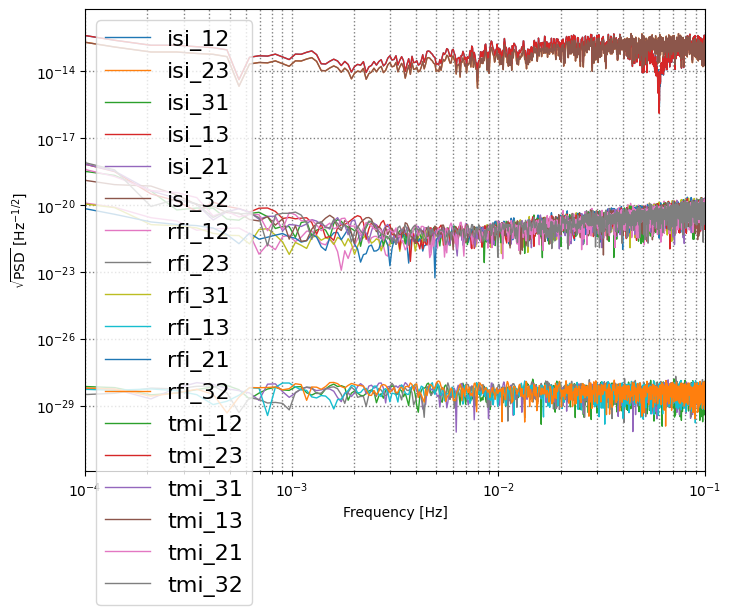

              total        used        free      shared  buff/cache   available
Mem:       15911324     2791456    10897536        1276     2222332    12808612
Swap:             0           0           0


In [34]:
import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
for i in range(18):
    axes.loglog(f[ipos], np.abs(y_fft[i][ipos]), 
            label=names18[i], linewidth=1)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

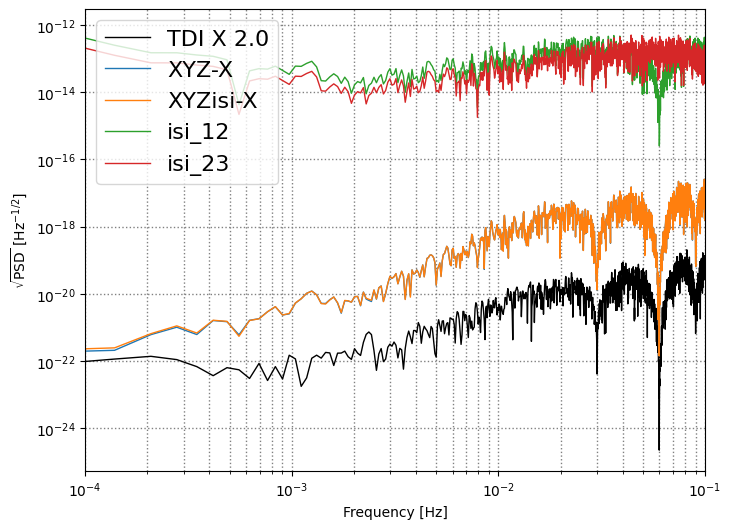

              total        used        free      shared  buff/cache   available
Mem:       15911324     2811324    10877436        1276     2222564    12788476
Swap:             0           0           0


In [35]:
import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
axes.loglog(f[ipos], np.abs(x2_fft[ipos]), 
            label='TDI X 2.0', 
            color='black', linewidth=1)

axes.loglog(f[ipos], np.abs(XYZ_fft[0][ipos]), 
            label='XYZ-X', linewidth=1)
#axes.loglog(f[ipos], np.abs(XYZc_fft[0][ipos]), 
#            label='XYZc-X', linewidth=1)
axes.loglog(f[ipos], np.abs(XYZ_isi_fft[0][ipos]), 
            label='XYZisi-X', linewidth=1)

axes.loglog(f[ipos], np.abs(Ysl0_fft[ipos]), 
            label=names18[0], linewidth=1)
axes.loglog(f[ipos], np.abs(Ysl1_fft[ipos]), 
            label=names18[1], linewidth=1)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

Using all 18 channels and equal arms, it looks like the results (at least for X) are very close to the file results.

Let's see what happens with a time varying implementation.

In [36]:

from pyfftw.interfaces.numpy_fft import rfft

def do_ft(dataset, fs=fs):
    ns=dataset.n_samples()
    wd=np.blackman(ns)
    f = np.fft.rfftfreq(ns) * fs
    sel=f>0
    print(sel)
    dataset_fft=[rfft(wd * dataset.data[i] ) * np.sqrt(2/(fs*k2)) for i in range(dataset.n_channels())]
    
    return f[sel], np.array(dataset_fft)[:,sel]


XYZ_file_noise = TimeData(np.array([x2_noise,y2_noise,z2_noise], dtype=np.float64)[:,skip:],dt=1/fs,names='XYZ')


[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
              total        used        free      shared  buff/cache   available
Mem:       15911324     3035604    10653124        1276     2222596    12564196
Swap:             0           0           0


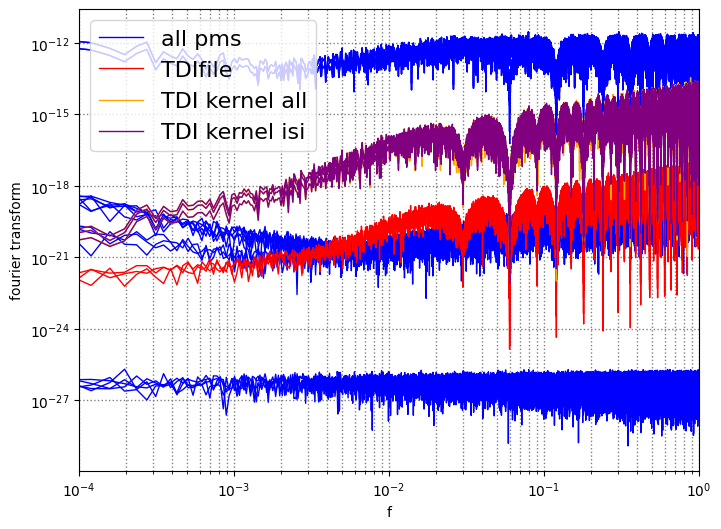

In [37]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 10
i0=iev

f,data=do_ft(y_td)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[0], label='all pms')
for i in range(1,18):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[0])
    
#print(f)    
#f,data=do_ft(y_isi_td)
#axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[1], label='isi')
#for i in range(1,6):
#    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[1])
    
f,data=do_ft(XYZ_file_noise)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[2], label='TDIfile')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[2])
        
f,data=do_ft(XYZ)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[3], label='TDI kernel all')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[3])
    
f,data=do_ft(XYZ_isi)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[4], label='TDI kernel isi')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[4])

    
    
axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

## More precise reverse engineering
More precisely, what we apply in our filtering code is a kernel or filter kernel which is based combines various time-shifted samples of the input streams to get a single time sample of the output streams. The above treatment estimates the kernel from the impulse response at one moment of the input which contributes to several time-shifted samples of output.  These are equivalent in the limit that the kernel doesn't vary with sample time.  We find that we cannot completely ignore the evolution of the kernel even across its width, though, so we need a more accurate version. 

In [38]:
###Now we reorganize pack that all into a neat bundle
def compute_TDI_kernel_exact(noise_data,i0=0,pastwidth=300,buffer=0,inchans=inchans18):
    # This version applies input impulse response across with impulses across the full width of the kernel 
    # but response only taken from the i0 point.
    # It may be somewhat slow, so that an approximation might be considered...TBD
    # For simplicity, we only treat the case where the kernel is strictly non-future-supported 
    #
    # pastwidth should be the full width of the (past-dominated) kernel which also includes i0
    # buffer is extra width on each side to include in the impulse response calculation
    
    mosas_order = ['12', '23', '31', '13', '21', '32']

    
    # 1. First we restrict to a relevant stretch of data
    istart=i0-(pastwidth-1)-buffer
    iend=i0+buffer+pastwidth #We add pastwidth to ensure that there is room for the forward kernel from i0
    assert istart>=0, "out of range at start"

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][istart:iend]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][istart:iend]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][istart:iend]

    names=[]
    for chan in inchans:
        for link in mosas_order:
            name=f'{chan}_{link}'
            names.append(name)
    nchan_in=len(names)
            
    for name in names:
        data=np.zeros((iend-istart,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)

    # 2. Get the zero-response
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])[:,i0-istart]

    # 3. Now get the single-point-impulse-responses to populate the kernel
    kernel = np.zeros((3,pastwidth,nchan_in))
    for ilink in range(nchan_in):
        name=names[ilink]
        print(name)
        for j in range(pastwidth): #loop over points in the kernel
            measurements_1=copy.deepcopy(measurements_z)
            #name=f'isi_{link}'
            measurements_1[name][i0-j-istart]=1
            kernel[:,pastwidth-j-1,ilink]=np.array([op(measurements_1) for op in XYZ_ops])[:,i0-istart]-XYZ_z

    return kernel

###Now we reorganize pack that all into a neat bundle
def compute_TDI_kernel_linear(noise_data,i0=0,pastwidth=300,buffer=20,inchans=inchans18):
    # This version applies input impulse response across with impulses at each end of the kernel spanning
    # the pastwidth and linearly interpolates inbetween.
    #
    # pastwidth should be the full width of the (past-dominated) kernel which also includes i0
    # buffer is extra width on each side to include in the impulse response calculation
    
    mosas_order = ['12', '23', '31', '13', '21', '32']
    
    # 1. First we restrict to a relevant stretch of data
    istart=i0-(pastwidth-1)-buffer
    iend=i0+buffer+pastwidth #We add pastwidth to ensure that there is room for the forward kernel from i0
    assert istart>=0, "out of range at start"

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][istart:iend]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][istart:iend]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][istart:iend]
        
    names=[]
    for chan in inchans:
        for link in mosas_order:
            name=f'{chan}_{link}'
            names.append(name)
    nchan_in=len(names)
    
    for name in names:
        data=np.zeros((iend-istart,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)

    # 2. Get the zero-response
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])

    # 3. Now get the full set of responses for the endpoints of the kernel
    samp_points=np.array([0,pastwidth-1])
    samp_coeffs = np.zeros((2,3,pastwidth,nchan_in))
    for isamp in range(2):
        jsamp=samp_points[isamp]
        for ilink in range(nchan_in):
            name=names[ilink]
            print(name)
            measurements_1=copy.deepcopy(measurements_z)
            iimpulse=i0-istart-jsamp
            measurements_1[name][iimpulse]=1
            samp_coeffs[isamp,:,:,ilink]=np.array([op(measurements_1) for op in XYZ_ops])[:,iimpulse:iimpulse+pastwidth]-XYZ_z[:,iimpulse:iimpulse+pastwidth]

    # 4. Now interpolate
    so=samp_coeffs[0]
    print('sc0 max',np.max(so),np.unravel_index(so.argmax(), so.shape))
    print('sc0 min',np.min(so),np.unravel_index(so.argmin(), so.shape))
    so=samp_coeffs[1]
    print('sc1 max',np.max(so),np.unravel_index(so.argmax(), so.shape))
    print('sc1 min',np.min(so),np.unravel_index(so.argmin(), so.shape))
    print(samp_coeffs[0])
    
    print('sc0,sc1 (pretranspose) at [1,249,0]',samp_coeffs[0][1,249,0],samp_coeffs[1][1,249,0])
    samp_coeffs=samp_coeffs.transpose(0,1,3,2)
    ioff=list(range(pastwidth))
    eps = (ioff-samp_points[0])/(samp_points[1]-samp_points[0])
    print(eps)
    kernel=samp_coeffs[0]*(1-eps)+samp_coeffs[1]*eps
    print('sc0,sc1,k at [1,0,249]',samp_coeffs[0][1,0,249],samp_coeffs[1][1,0,249],kernel[1,0,249])
    kernel=kernel.transpose(0,2,1)[:,::-1,:]

    return kernel#,samp_coeffs.transpose(0,1,3,2)
    

            
    

In [ ]:
i0test=5000
_,so=compute_TDI_kernel(data_noise,i0=i0test,nleft=1000,nright=2000)
sl=compute_TDI_kernel_linear(data_noise,i0=i0test,pastwidth=283,buffer=30)
se=compute_TDI_kernel_exact(data_noise,i0=i0test,pastwidth=283) #This takes about 10 minutes
print(so.shape,sl.shape,se.shape)


isi_12 min/max -1.0 (np.int64(0), np.int64(1000)) 0.94195636214032 (np.int64(1), np.int64(1233))
isi_23 min/max -1.0 (np.int64(1), np.int64(1000)) 0.9927100786065521 (np.int64(1), np.int64(1133))
isi_31 min/max -1.0 (np.int64(2), np.int64(1000)) 0.9140882471040888 (np.int64(0), np.int64(1233))
isi_13 min/max -0.9695475690801881 (np.int64(2), np.int64(1233)) 1.0 (np.int64(0), np.int64(1000))
isi_21 min/max -0.992710269433983 (np.int64(1), np.int64(1133)) 1.0 (np.int64(1), np.int64(1000))
isi_32 min/max -0.9549719377141639 (np.int64(1), np.int64(1233)) 1.0 (np.int64(2), np.int64(1000))
rfi_12 min/max -0.9082024365416865 (np.int64(1), np.int64(1100)) 0.9539282868900627 (np.int64(0), np.int64(1200))
rfi_23 min/max -0.9999465153470557 (np.int64(2), np.int64(1100)) 0.9927100786065521 (np.int64(1), np.int64(1133))
rfi_31 min/max -0.9854622591945386 (np.int64(0), np.int64(1100)) 0.9993759064511082 (np.int64(2), np.int64(1200))
rfi_13 min/max -0.994665768110253 (np.int64(0), np.int64(1200)) 0.9

In [ ]:
print('so max',np.max(so),np.unravel_index(so.argmax(), so.shape))
print('so min',np.min(so),np.unravel_index(so.argmin(), so.shape))
print('sl max',np.max(sl),np.unravel_index(sl.argmax(), sl.shape))
print('sl min',np.min(sl),np.unravel_index(sl.argmin(), sl.shape))
display(so)
display(sl)

#Compare (-1)*old vs exact kernels
deltao = so - se
deltaol = so - sl
delta = sl - se

print(so.shape)
plt.plot((so-se)[0,:,9],label="o-e")
plt.plot((sl-se)[0,:,0],label="l-e")
#plt.plot(sl[0,:,0]-se[0,:,0])
print("o",np.min(so),np.max(so),np.std(so))
print("l",np.min(sl),np.max(sl),np.std(sl))
print("e",np.min(se),np.max(se),np.std(se))
print('o-e',np.min(deltao),np.max(deltao),np.std(deltao))
print('o-l',np.min(deltaol),np.max(deltaol),np.std(deltaol))
print('l-e',np.min(delta),np.max(delta),np.std(delta))
deltarel=delta/[1e-300+se]
print("l-e rel",np.min(deltarel),np.max(deltarel),np.std(deltarel))
deltarel=deltaol/[1e-300+se]
print("o-l rel",np.min(deltarel),np.max(deltarel),np.std(deltarel))
deltarel=deltao/[1e-300+se]
print("o-e rel",np.min(deltarel),np.max(deltarel),np.std(deltarel))

plt.legend()



In [ ]:
#Compare code vs old kernels
sc=tdifilt.kernel_compts
#display(sc)
#display(so)
delta = sc - so
#display(delta)
print(np.min(delta),np.max(delta),np.std(delta))
deltarel=delta/[1e-300+sc]
print(np.min(deltarel),np.max(deltarel),np.std(deltarel))

In [ ]:
test_hours = 1
test_len =  int(test_hours * 3600 * fs)
ytest=TimeData(y_full[0:test_len,:].T, dt=1/fs,names=names18)
print(ytest.data.shape)

XYZcode=tdifilt.apply_filter(ytest,method='convolve')

tdifilt_se=TDIFilter(data_noise,eval_time=1000/fs,in_chans=inchans18)
tdifilt_se.kernel_compts=se
XYZse=tdifilt_se.apply_filter(ytest,method='convolve')

tdifilt_sl=TDIFilter(data_noise,eval_time=1000/fs,in_chans=inchans18)
tdifilt_sl.kernel_compts=sl
XYZsl=tdifilt_sl.apply_filter(ytest,method='convolve')

In [ ]:
ixyz=0
iev=1
plt.semilogy(XYZcode.data[ixyz][::iev],label="code")
plt.semilogy(XYZse.data[ixyz][::iev],label="se")
#plt.semilogy(XYZcode.data[ixyz]-XYZse.data[ixyz],label="code - se")
plt.semilogy((XYZcode.data[ixyz]-XYZse.data[ixyz])[::iev],label="code - se")
plt.semilogy((XYZsl.data[ixyz]-XYZse.data[ixyz])[::iev],label="sl - se")
plt.legend()

In [ ]:
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 
ixyz=0
iev = 100
i0=iev

f,data=do_ft(XYZ_file_noise)
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[0], label='pyTDI-'+'XYZ')

iev=10

f,data=do_ft(XYZcode)
datac=data
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[1], label='code-'+'XYZ'[ixyz])
    
f,data=do_ft(XYZse)
datae=data
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[2], label='exact-'+'XYZ'[ixyz])

data=datac-datae
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[3], label='code-'+'XYZ'[ixyz]+' - exact-'+'XYZ'[ixyz])

f,data=do_ft(XYZsl)
datal=data
data=datal-datae
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[4], label='linear-'+'XYZ'[ixyz]+' - exact-'+'XYZ'[ixyz])

    
    
axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()

For equal-arm data, the results look very much like those from the isi only case.    

With kepler the suppression is only to 1e-13 but I am not seeing the near-kernel optimum I expect

In [ ]:
def PSD_model_TDI2X(f):
    #This is a low-res LISA residual noise model which does not take into account correlations, orbits, or spacecraft specific variations
    S_TM  = 9e-30*(1+(0.0004/f)**2)*(1+(f/0.008)**4)*(f/5.3088374589e-10)**2 #m^2/s^3
    S_OMS = 225e-24*(1+(0.002/f)**4)*(f/4.7713451592e7)**2  #m^2s
    #S_eta = S_OMS+2*S_TM
    #S_eta_eta_x = <eta eta_x^*> = (D^*+D)S_TM
    #X2 = (1-D^4)X_1
    #X1 = (1-D^4)[(1-D D)(eta + D eta_x)-(1-D D)(eta' + D eta'_x)] with different links on each of the etas and Ds 
    #Thus S_X1 ~ 2*|1-DD|^2*( (2*S_eta ) + (D^*+D)^2*S_eta_eta_x 
    #         ~ 16 * sin(2pi f L/c)^2 * ( S_eta + 2*cos(2pi f L/c)^2 S_TM )
    #         ~ 16 * sin(2pi f L/c)^2 * ( S_OMS + 2*(1+cos(2pi f L/c)^2) S_TM )
    # and S_X2 ~ (2*sin(4pi f L/c)^2 * S_X1
    #For a simplified, non-oscillatory, approximation sin(2pi f L/c)^2  ~ 0.5 * ( 1 + 0.5 / (2pi f L/c)**2 )^-1 ~ 0.5 / (1+(0.0135/f)**2)
    #Similarly, n sin(2pi f L/c)^2 ~ 0.5 * ( 1 + 0.5 / (4pi f L/c)**2 )^01 ~ 0.5 / (1+(0.0068/f)**2)
    # and cos( 2pi f L/c)^2 ~ 1/2 
    S_X = 64 / ( 1 + (0.0068/f)**2 ) / ( 1 + (0.0135/f)**2 ) * (S_OMS + 3 * S_TM ) 